In [1]:
# Example dataset

# !mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
# !mkdir write

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np

import scout

In [3]:
adata = sc.read_10x_mtx('data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [4]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [5]:
scout.tl.scale_log_center(adata, target_sum=1e4)

In [6]:
sc.tl.pca(adata)
sc.pp.neighbors(adata, random_state=0)
sc.tl.leiden(adata, random_state=0, resolution=0.1)

/home/lutrarutra/mambaforge/envs/scout/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/lutrarutra/mambaforge/envs/scout/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


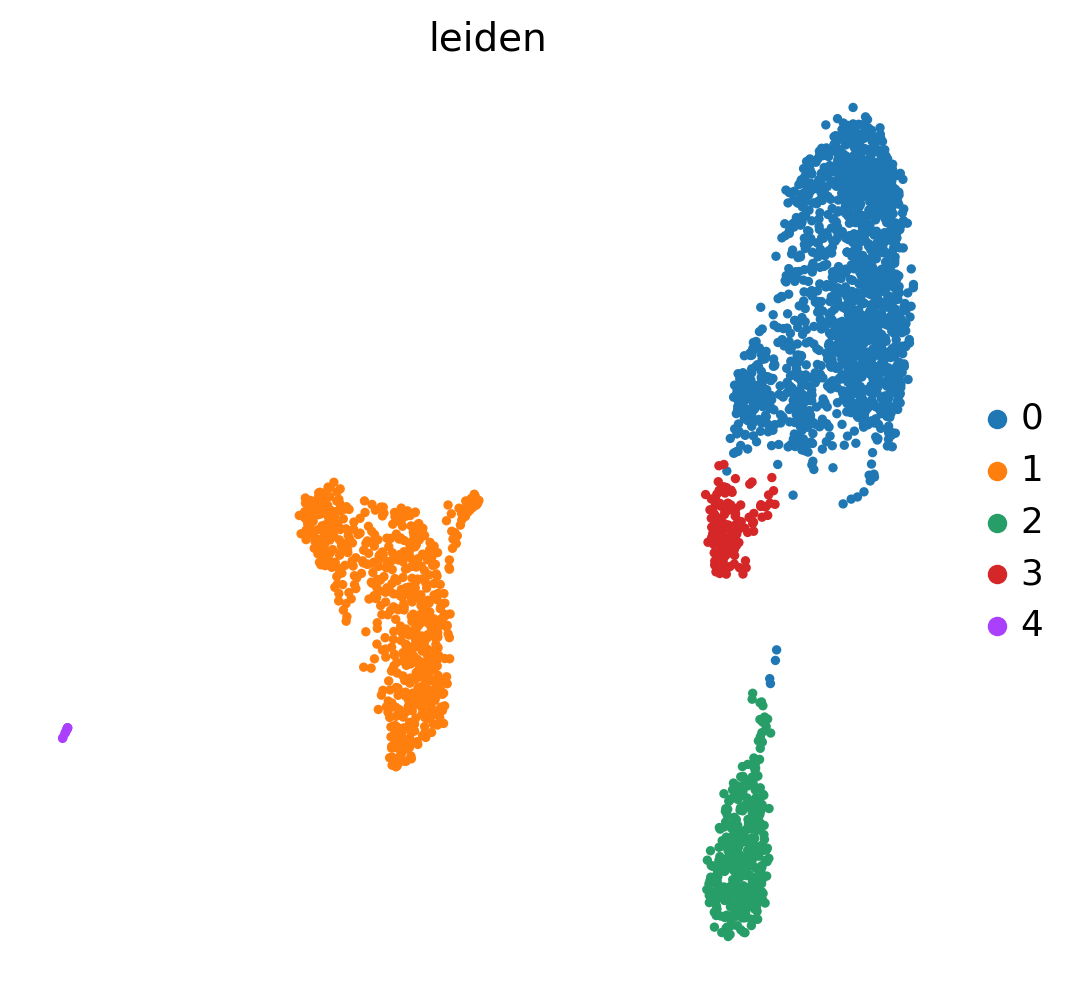

In [7]:
sc.settings.set_figure_params(figsize=(6,6), dpi=100, facecolor='white')
sc.tl.umap(adata, random_state=0)
sc.pl.umap(adata, color=["leiden"], frameon=False)

In [8]:
scout.tl.rank_marker_genes(adata, groupby="leiden")

/home/lutrarutra/mambaforge/envs/scout/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/lutrarutra/mambaforge/envs/scout/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/lutrarutra/mambaforge/envs/scout/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/lutrarutra/mambaforge/envs/scout/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
# e.g. top 5 marker genes by abs score from: Leiden cluster '0' vs. rest
adata.uns["rank_genes_leiden"]['0'].sort_values("abs_score", ascending=False).head(5)

,z-score,pvals_adj,logFC,-log_pvals_adj,significant,mu_expression,log_mu_expression,gene_score,abs_score
0_vs_rest,,,,,,,,,
FTL,-38.838264,5.783257e-236,-2.394807,235.237827,True,6.170819,2.471153,-47.343469,47.343469
HLA-DRA,-55.261753,0.000000e+00,-5.089863,inf,True,0.441701,1.066605,-43.430974,43.430974
CD74,-42.175426,1.583550e-284,-3.120772,283.800368,True,1.748302,1.509965,-37.698064,37.698064
FTH1,-32.914642,6.811180e-182,-1.916090,181.166778,True,6.286727,2.365764,-36.264135,36.264135
MALAT1,30.707060,5.094630e-165,1.060928,164.292887,True,74.664536,3.928104,33.339495,33.339495


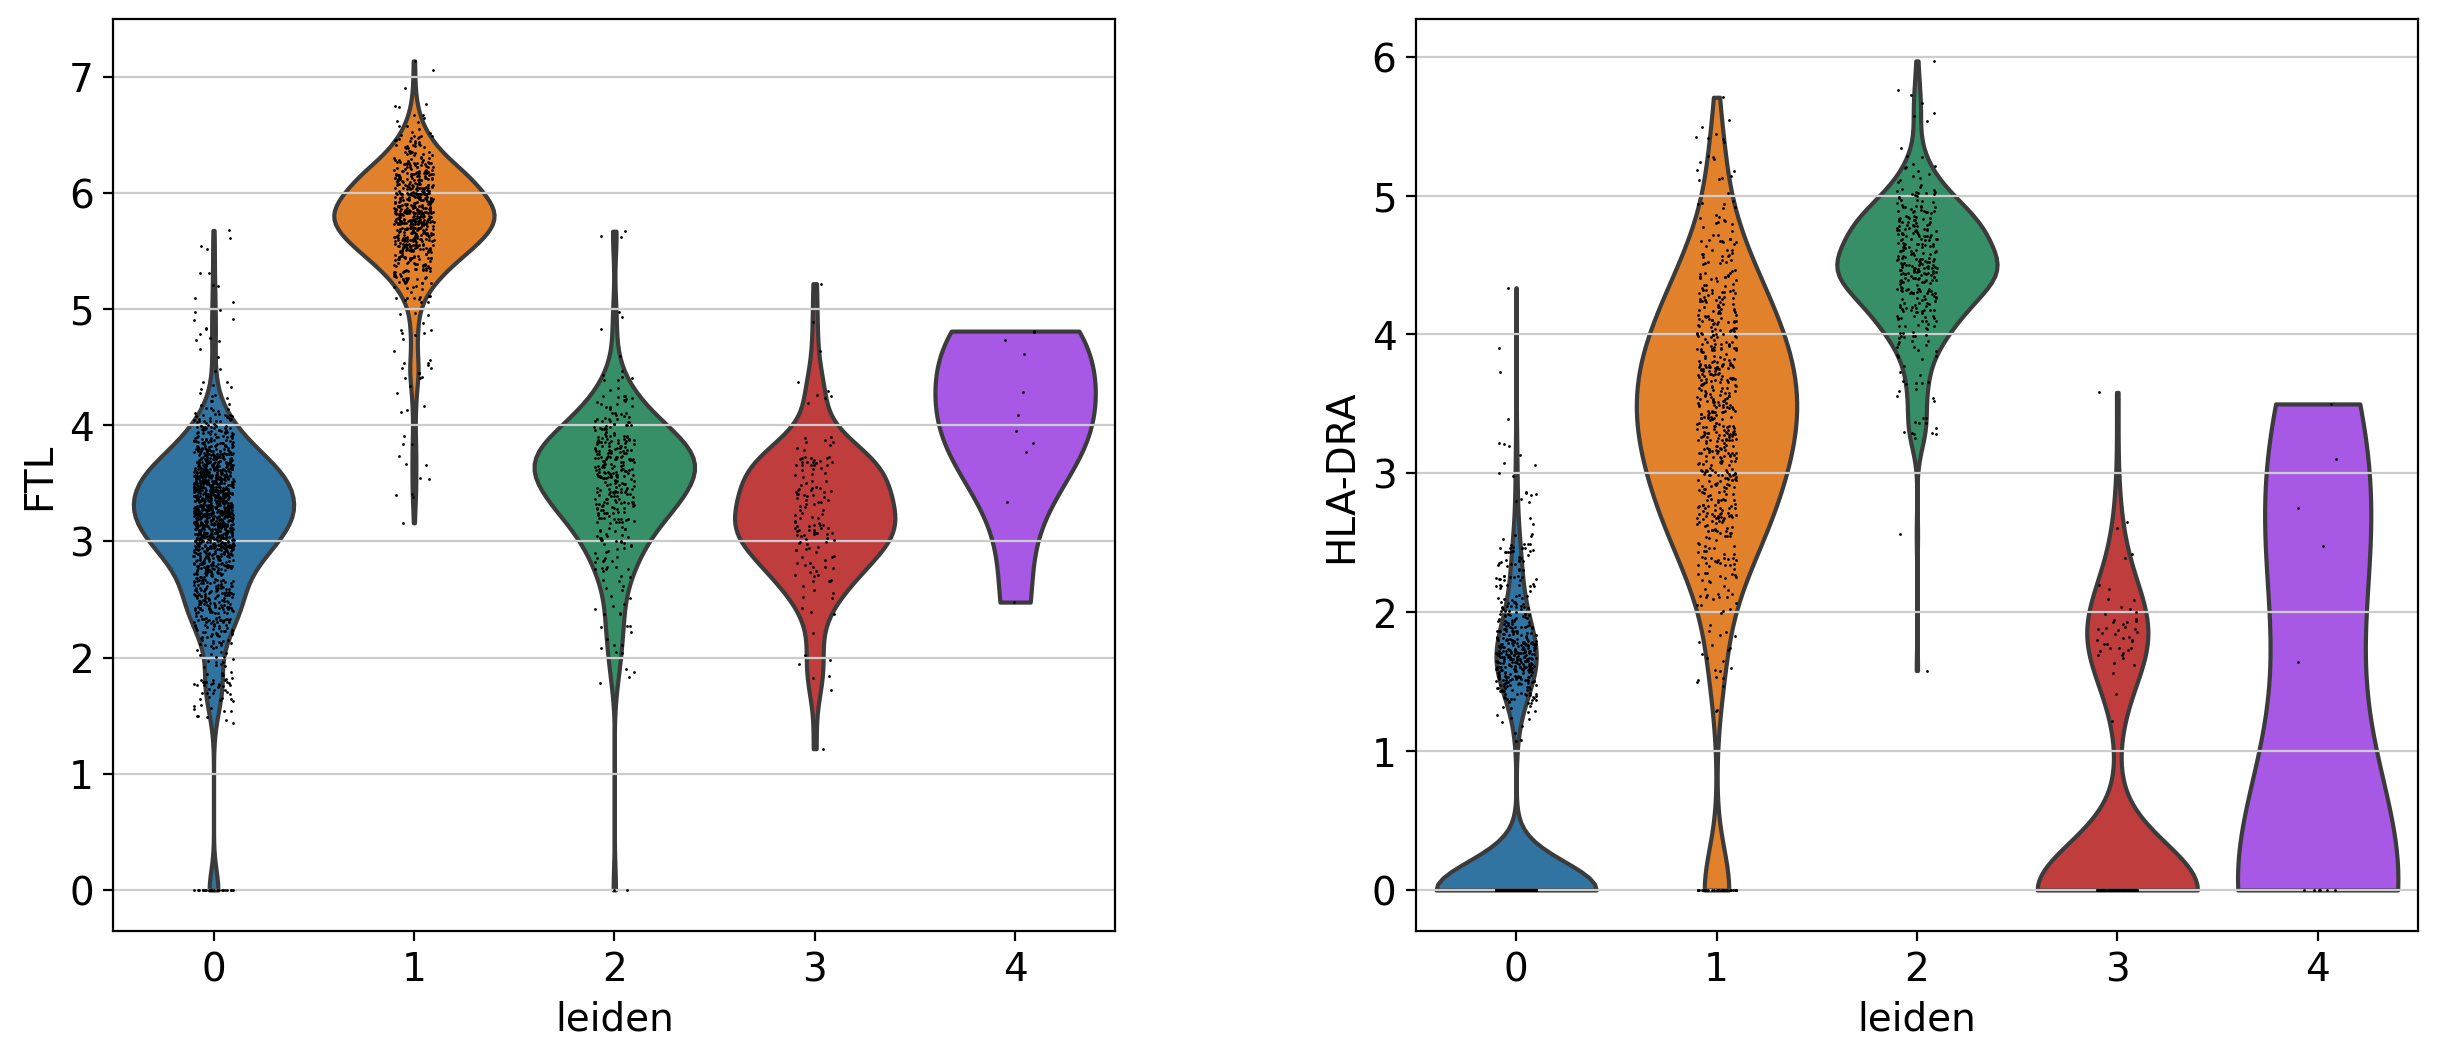

In [10]:
sc.pl.violin(adata, groupby="leiden", keys=adata.uns["rank_genes_leiden"]['0'].sort_values("abs_score", ascending=False).index[:2])

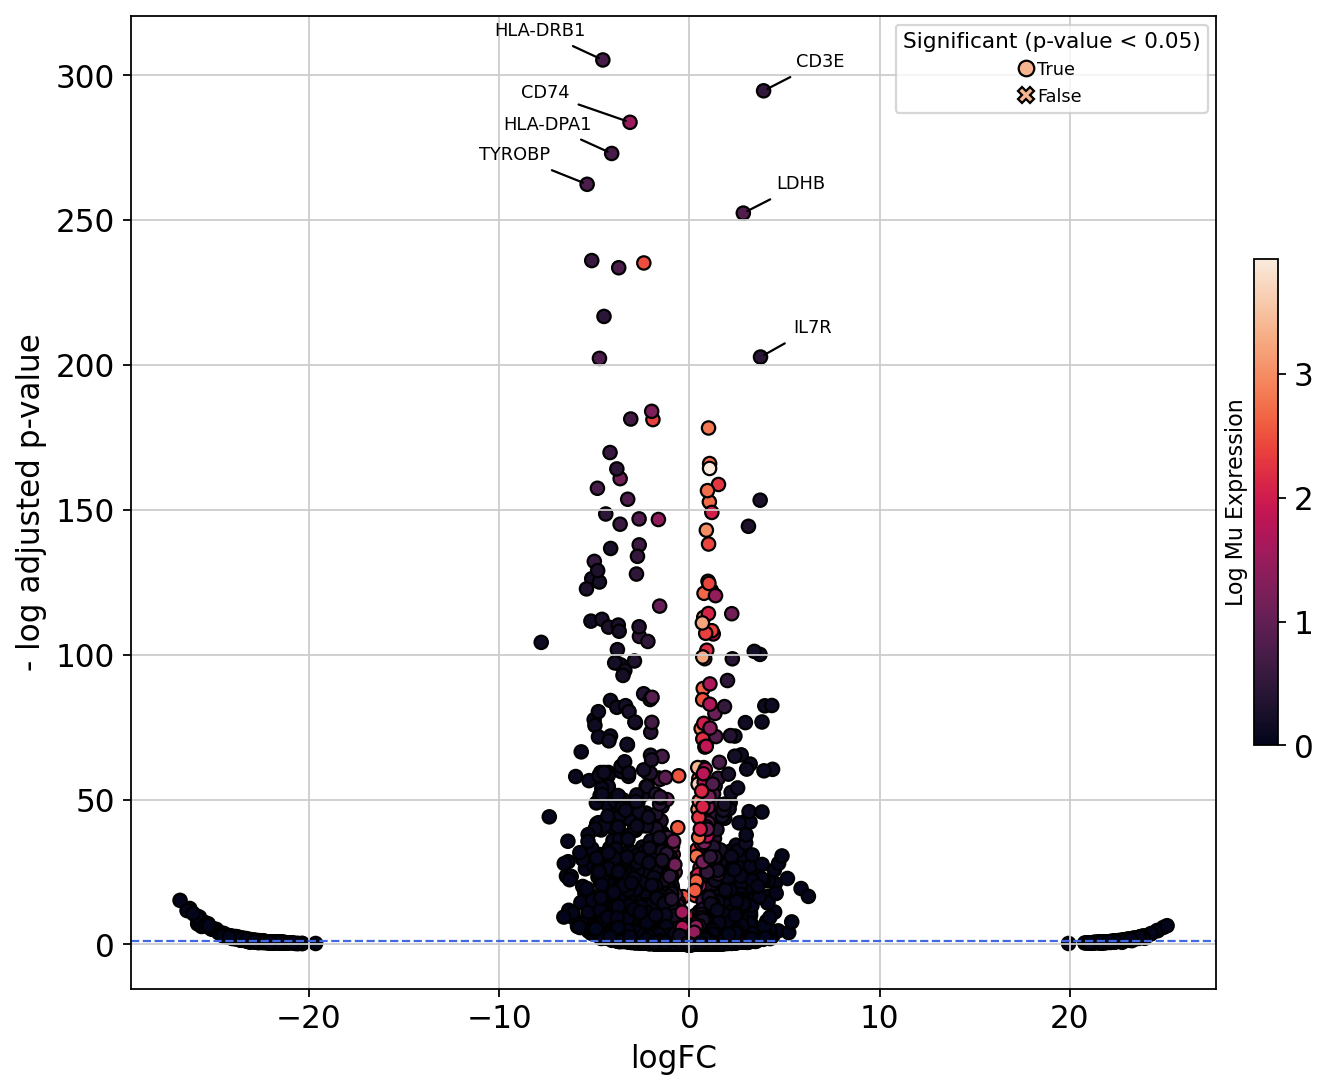

In [11]:
scout.pl.marker_volcano(adata.uns["rank_genes_leiden"]['0'], fig_path="figures/volcano.pdf")

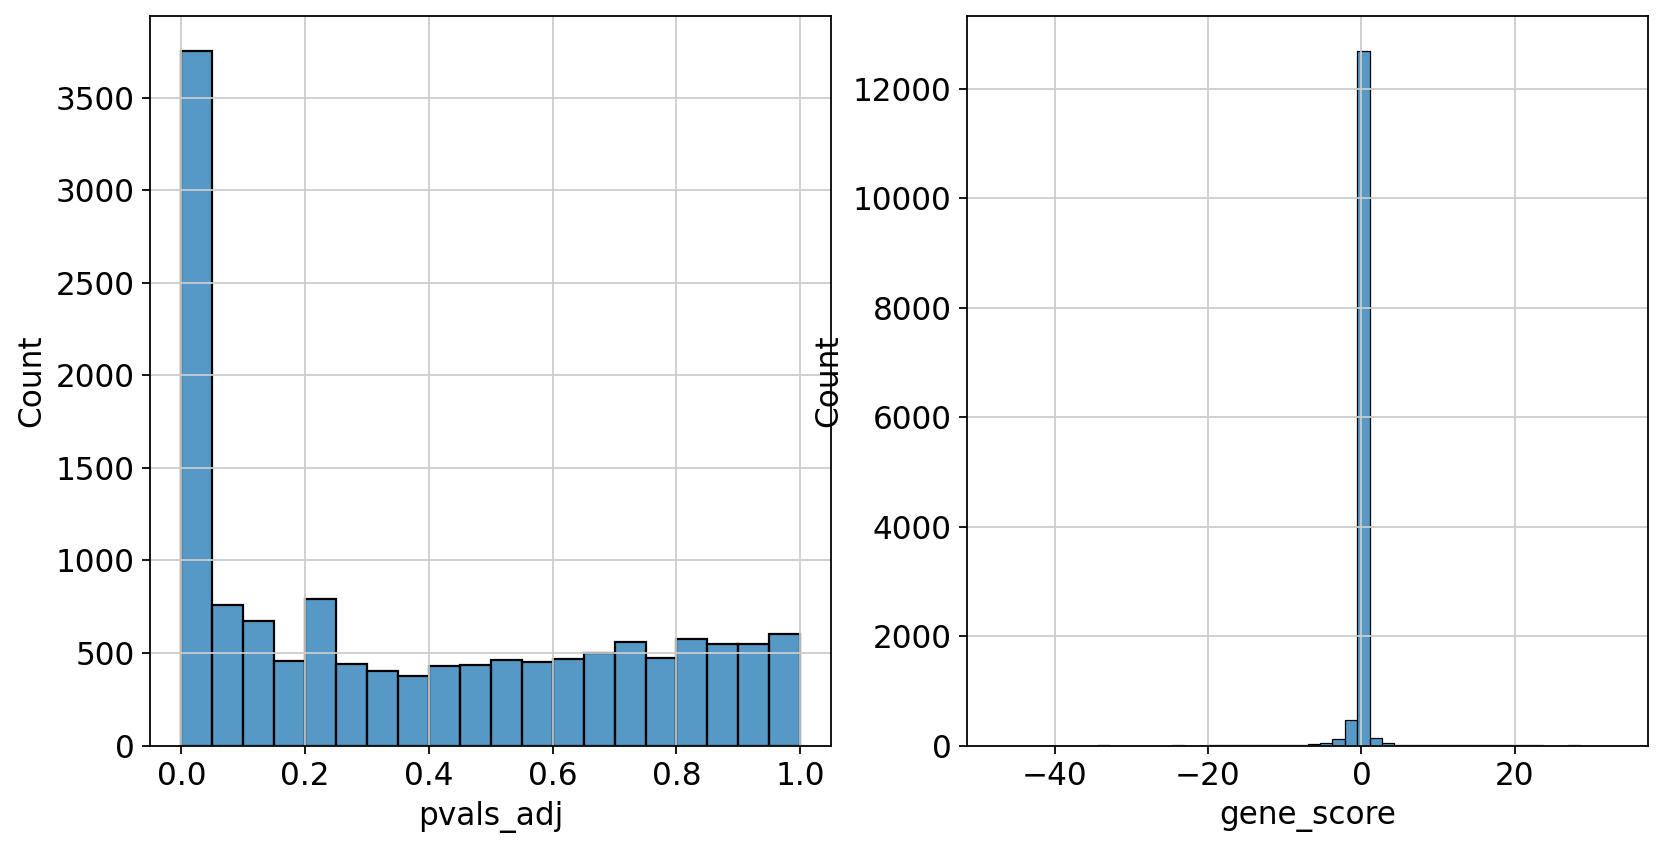

In [12]:
scout.pl.plot_marker_score_distributions(adata.uns["rank_genes_leiden"]['0'], fig_path="figures/score_distributions.pdf")

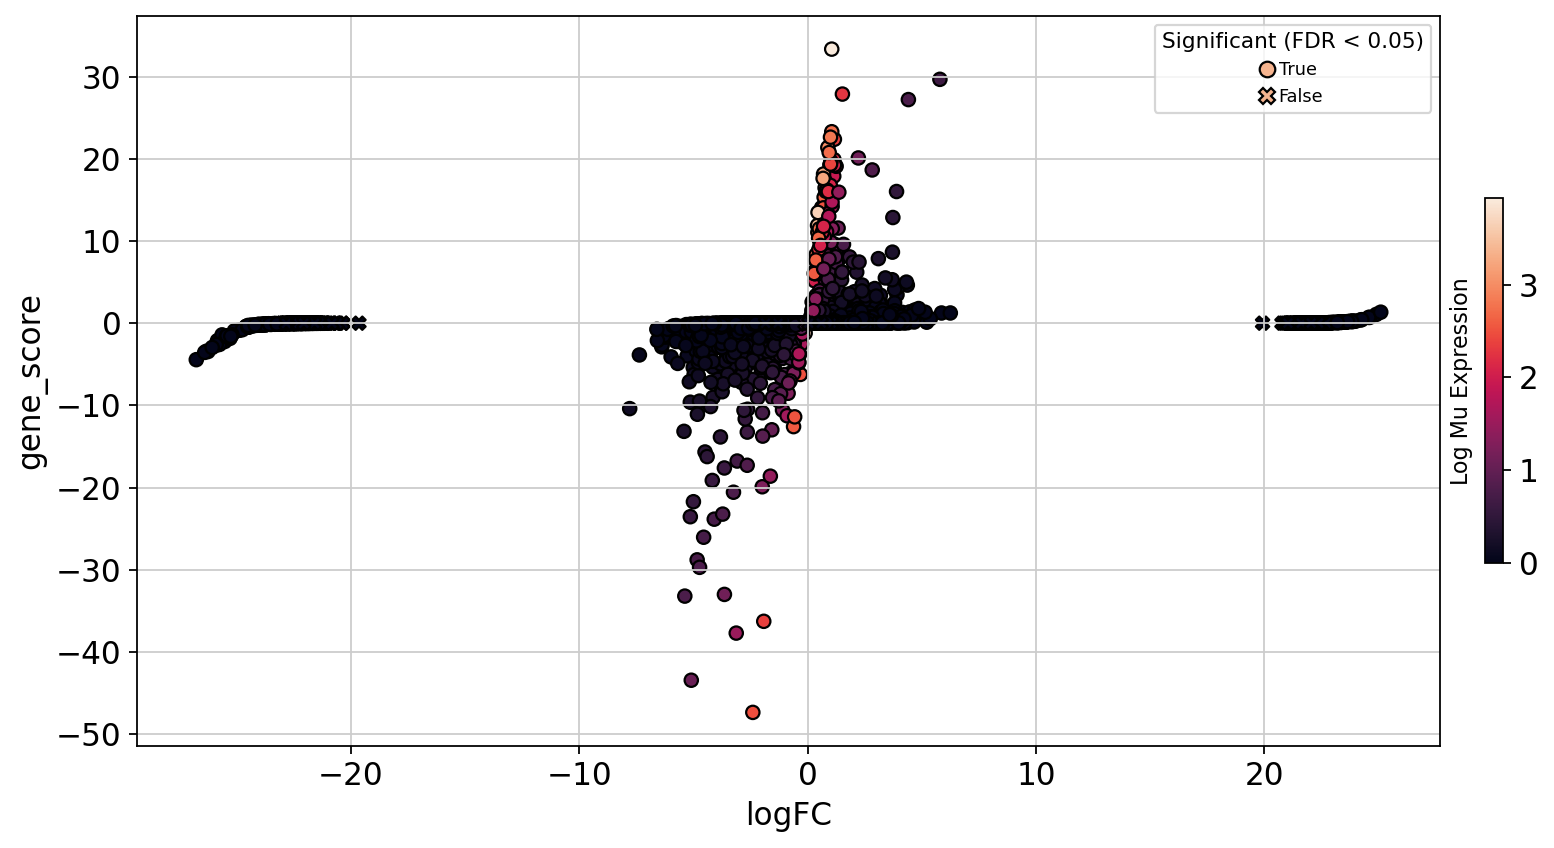

In [13]:
scout.pl.plot_marker_scores(adata.uns["rank_genes_leiden"]['0'], fig_path="figures/scores.pdf")

Using 150 cells from 4 leidens


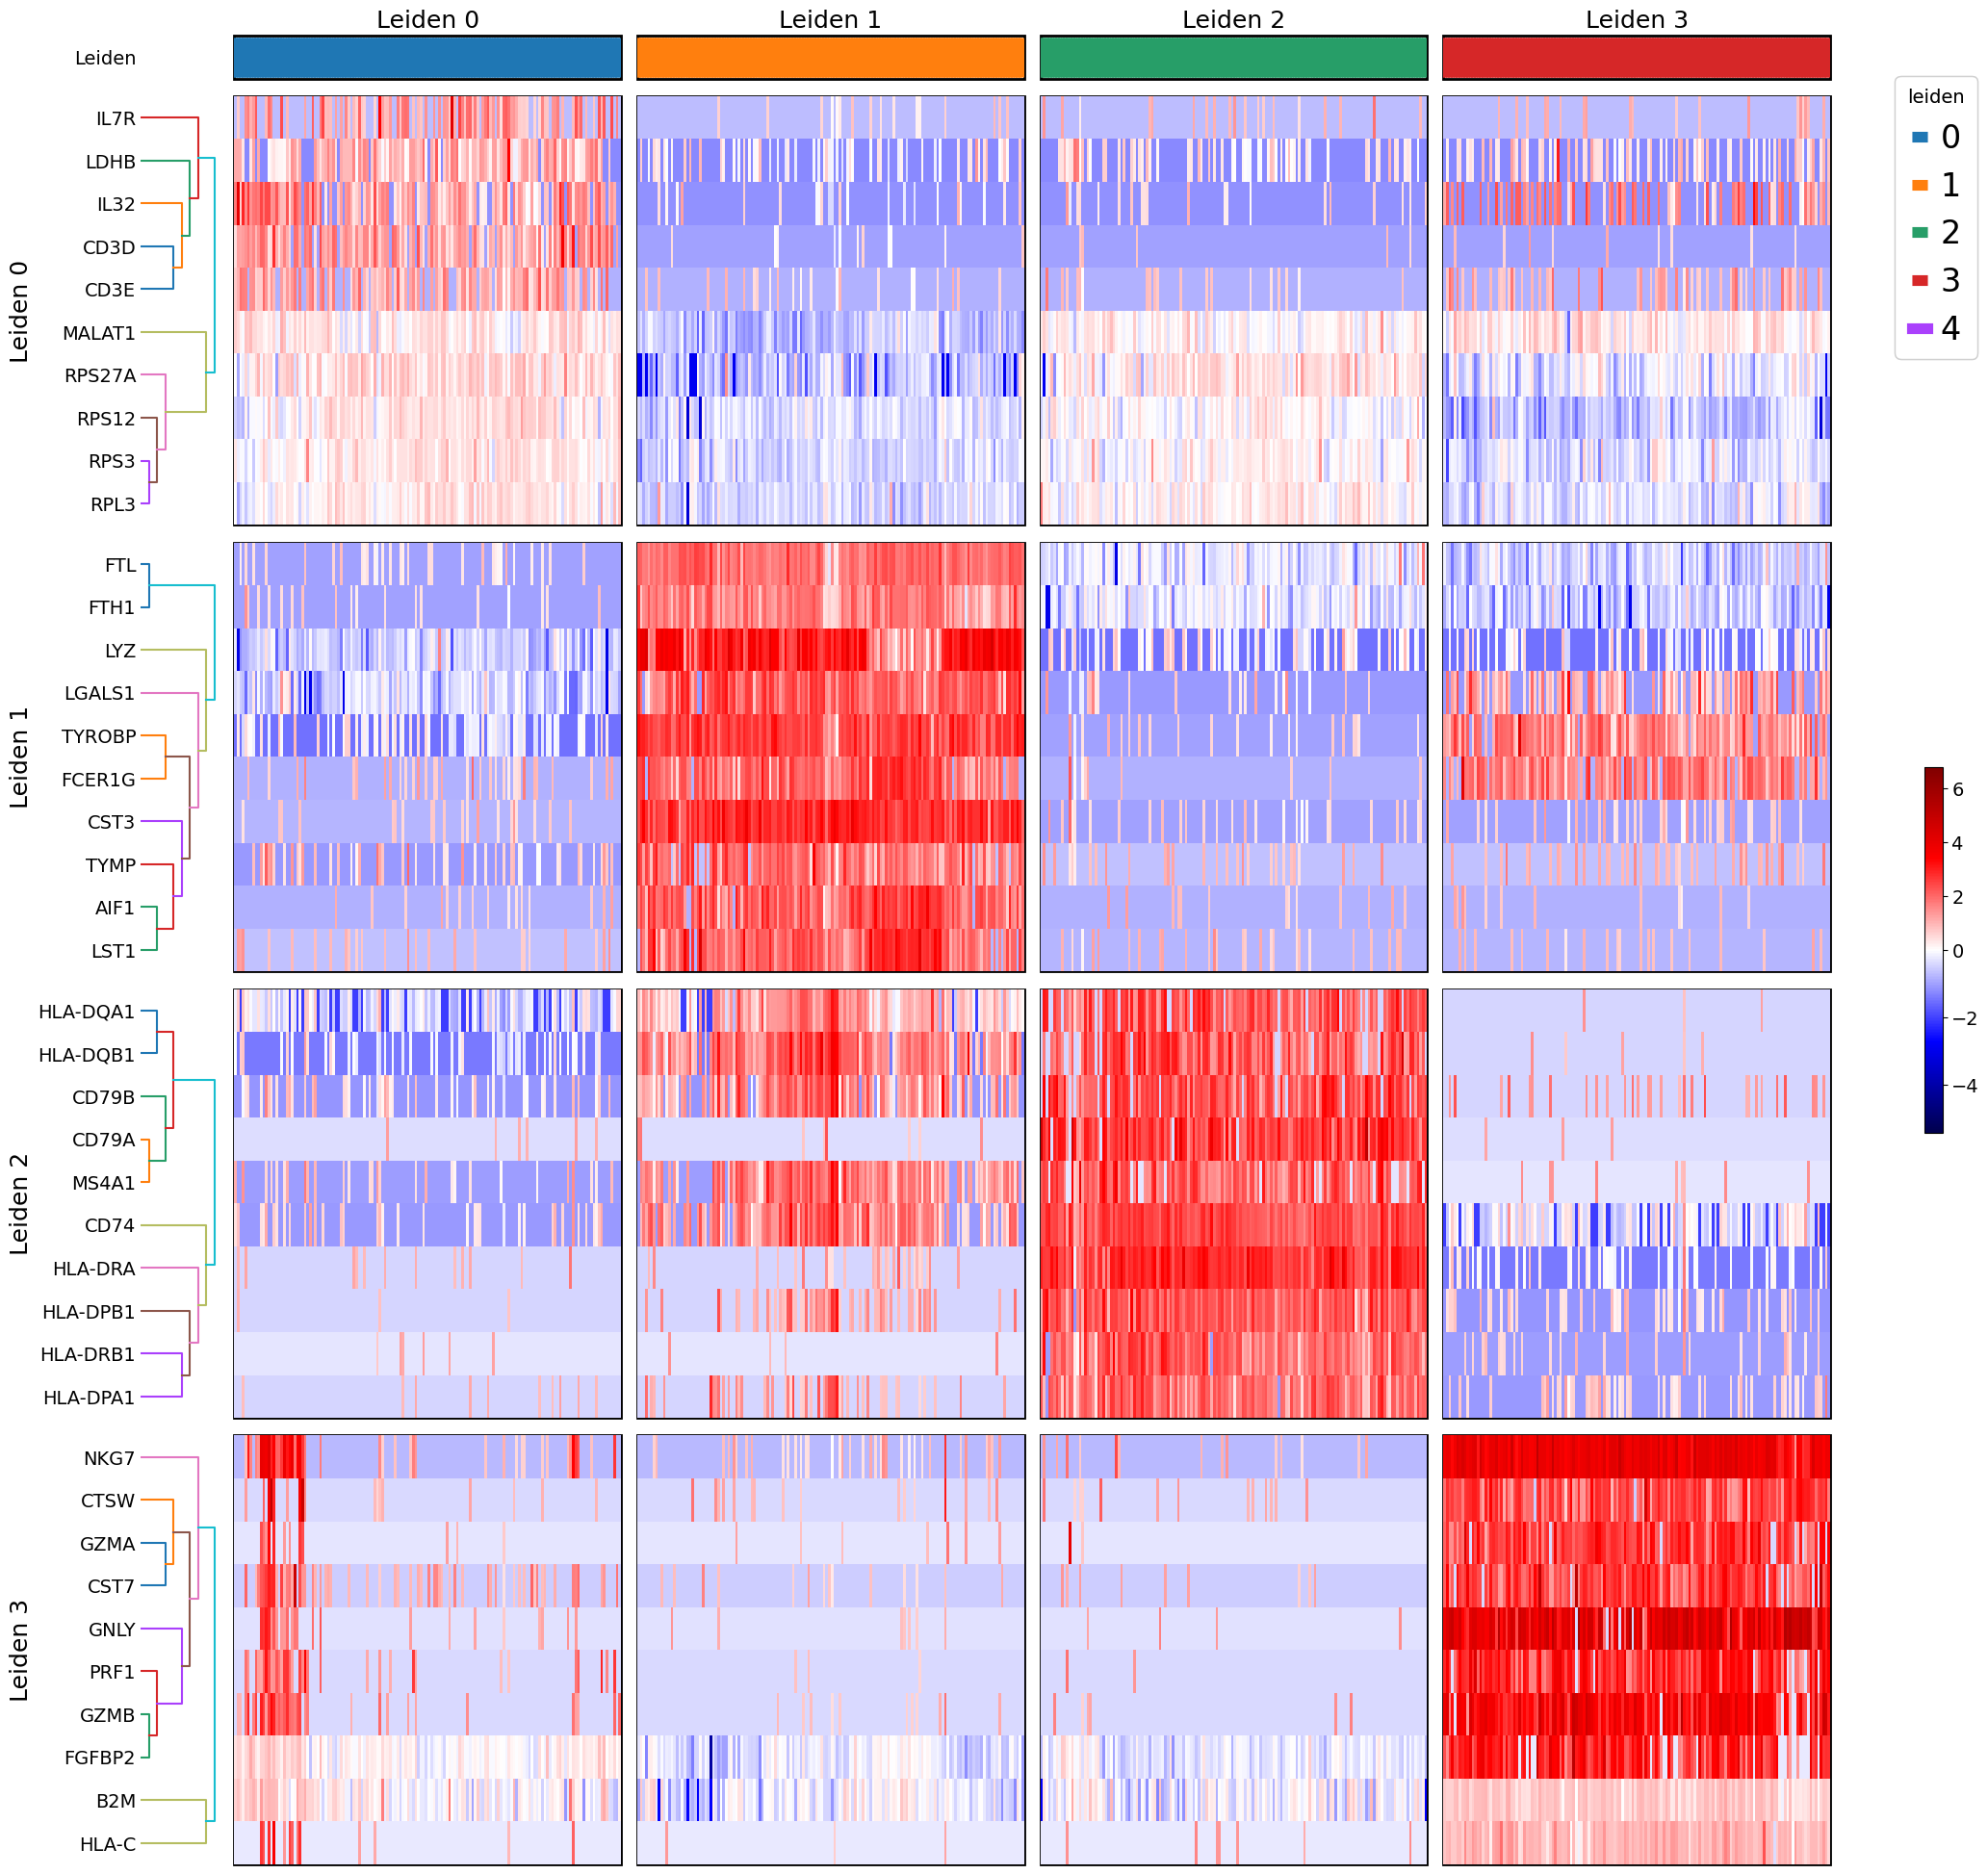

In [14]:
scout.pl.clustermap(adata, clusterby="leiden", categorical_features=["leiden"], n_genes=10, fig_path="figures/clustermap.pdf")

In [15]:
res = scout.tl.GSEA(adata.uns["rank_genes_leiden"]['0'], n_threads=12)
res.sort_values("fdr").head(10)[["Term", "nes", "fdr", "fwer", "matched_fraction", "matched_size", "geneset_size"]]

2022-11-28 16:27:28,209 Duplicated values found in preranked stats: 0.07% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
/home/lutrarutra/mambaforge/envs/scout/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Term,nes,fdr,fwer,matched_fraction,matched_size,geneset_size
0,Ribosome,1.667660,0.000000,0.000,0.562500,72,128
1,Coronavirus disease,1.645717,0.000000,0.000,0.417143,73,175
2,Tuberculosis,-1.497255,0.035771,0.025,0.257143,36,140
3,Herpes simplex virus 1 infection,-1.461292,0.074735,0.086,0.064593,27,418
4,Influenza A,-1.445286,0.100499,0.153,0.187970,25,133
9,Lysosome,-1.374981,0.383622,0.679,0.191304,22,115
14,Bacterial invasion of epithelial cells,-1.360214,0.391561,0.799,0.272727,15,55
12,Toxoplasmosis,-1.363527,0.402704,0.781,0.180851,17,94
5,Neutrophil extracellular trap formation,-1.391726,0.422222,0.537,0.237113,23,97
11,Staphylococcus aureus infection,-1.365527,0.427811,0.763,0.395349,17,43


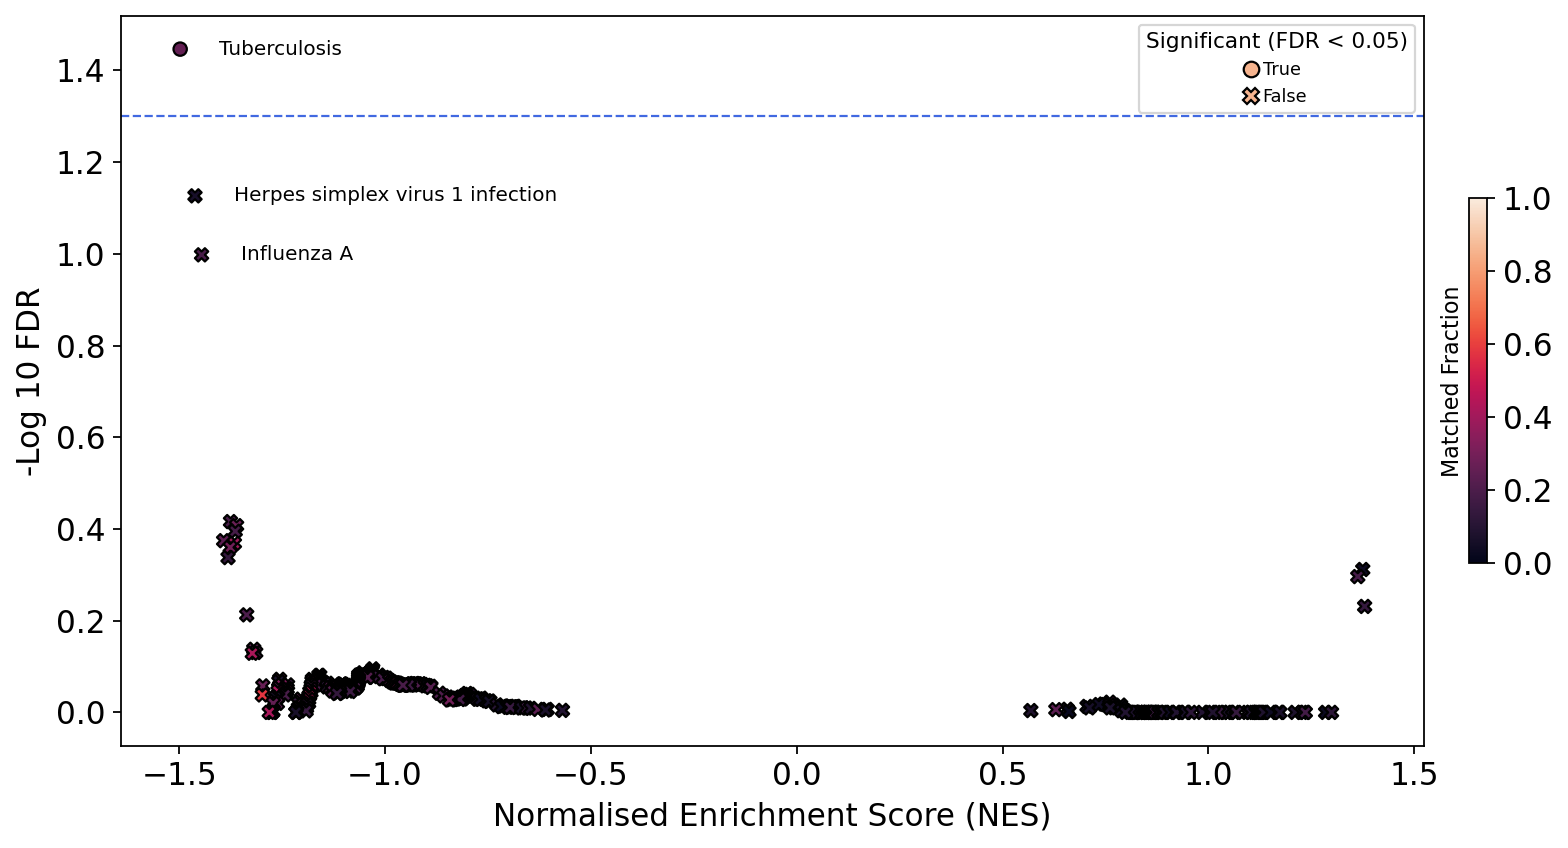

In [16]:
scout.pl.gsea_volcano(res, fig_path="figures/gsea_volcano.pdf")

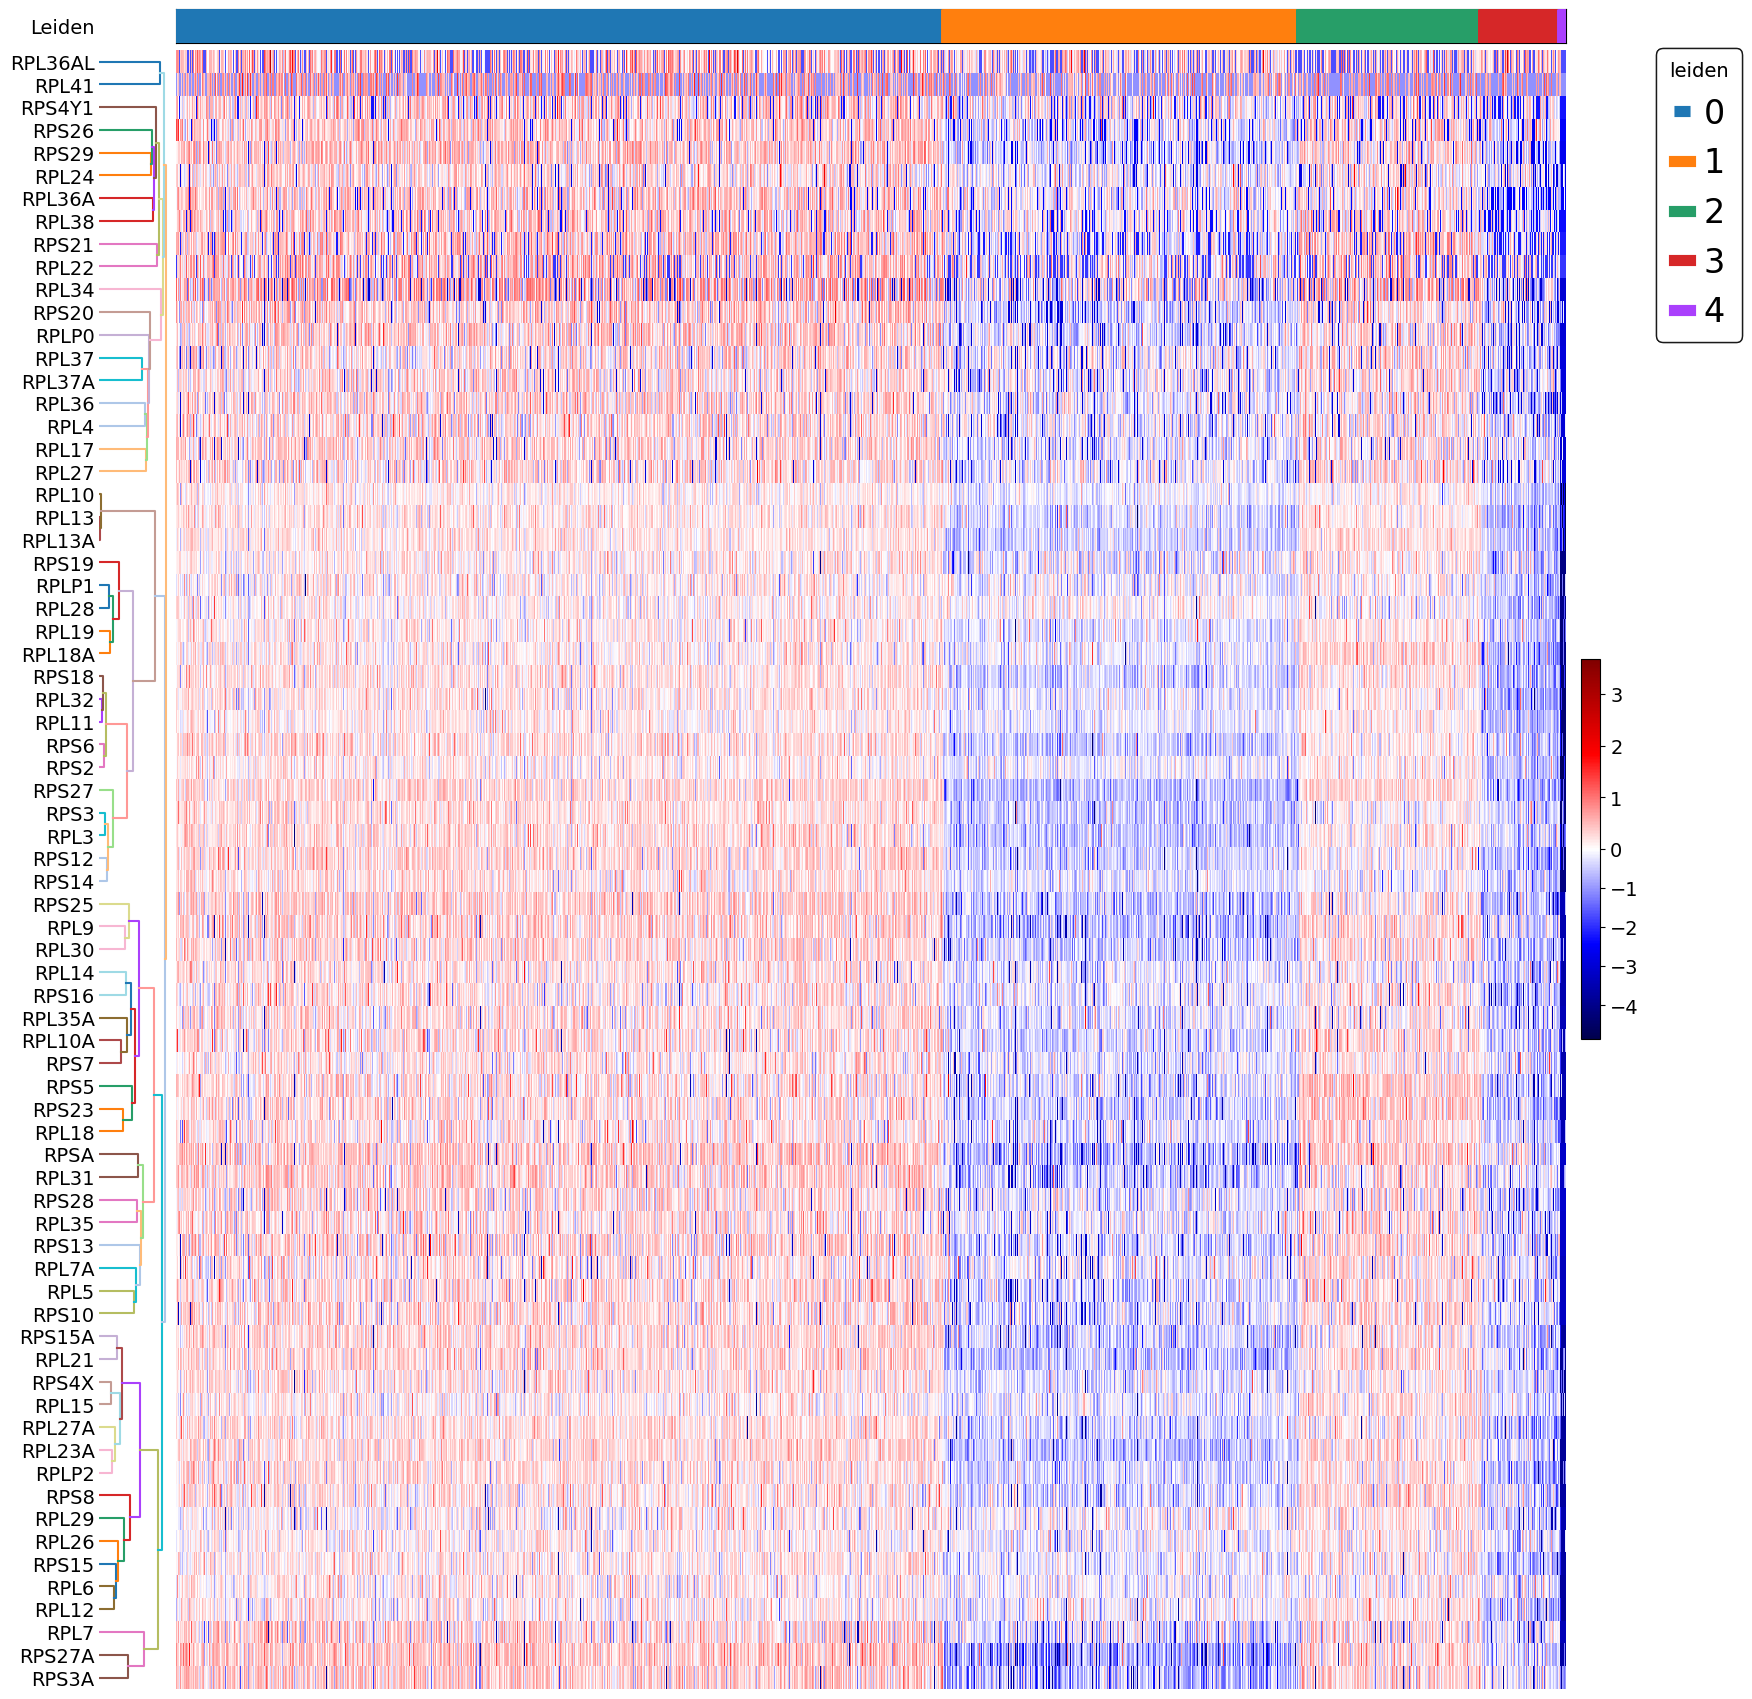

In [18]:
scout.pl.heatmap(
    adata, groupby="leiden", categorical_features=["leiden"],
    sort_cells=True, sort_genes=True, var_names=res.loc[0, "lead_genes"], n_genes=50, fig_path="figures/heatmap.pdf"
)